# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import transformers
from torch import nn
import torch
from multihead_models import *
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR

/hdd2/sonia/miniconda3/envs/great/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%reload_ext autoreload

## Distil GPT2

In [3]:
dgpt2 = transformers.AutoModelForCausalLM.from_pretrained('distilgpt2')
dgpt2

/hdd2/sonia/miniconda3/envs/great/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [4]:
num_experts = 3
dgpt2copy = MOEModelForCausalLM(dgpt2, num_experts=num_experts)
dgpt2copy

MOEModelForCausalLM(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MOEMLP(
          (mlps): ModuleList(
            (0-2): 3 x GPT2MLP(
              (c_fc): Conv1D()
              (c_proj): Conv1D()
              (act): NewGELUActivation()
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
instring = 'hello'

toks = tokenizer(instring, return_tensors='pt')
outs = dgpt2.forward(**toks)
outsmoe = dgpt2copy.forward(**toks)
assert outs.logits.equal(outsmoe[0])
assert dgpt2copy.generate(**toks).equal(dgpt2.generate(**toks))

In [8]:
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
instring = 'hello'

toks = tokenizer(instring, return_tensors='pt')
tokenizer.batch_decode(dgpt2.generate(**toks))

/hdd2/sonia/miniconda3/envs/great/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/hdd2/sonia/miniconda3/envs/great/lib/python3.11/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['hello The U.S. Department of Justice has been investigating the death of a man who was shot']

## Llama

In [8]:
llama = transformers.AutoModelForCausalLM.from_pretrained('/zoo/llama2/llama2-7b-hf', torch_dtype=torch.bfloat16)
llama

Loading checkpoint shards: 100%|██████████| 2/2 [00:15<00:00,  7.57s/it]
/hdd2/sonia/miniconda3/envs/great/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/hdd2/sonia/miniconda3/envs/great/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameteriza

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
 

In [9]:
llamacopy = MOEModelForCausalLM.from_other(llama)
llamacopy

deep copied model
added MOE MLPs


MOEModelForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): MOEMLP(
          (mlps): ModuleList(
            (0): LlamaMLP(
              (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
              (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
              (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
              (act_fn): SiLU()
            )
          )
        )
        (input_layernorm): LlamaRMS

In [19]:
from transformers import AutoTokenizer 
tokenizerllama = AutoTokenizer.from_pretrained("/zoo/llama2/llama2-7b-hf")
llama.cpu(), llamacopy.cpu()

instring = 'hello'
toks = tokenizerllama(instring, return_tensors='pt')
outs = llama.forward(**toks)
outsmoe = llamacopy.forward(**toks)
assert outs.logits.equal(outsmoe[0])
print('first assert passed')

outs = llama.cuda().generate(input_ids=toks['input_ids'].cuda(), attention_mask=toks['attention_mask'].cuda())
print('llama generation complete')
outsmoe = llamacopy.cuda().generate(input_ids=toks['input_ids'].cuda(), attention_mask=toks['attention_mask'].cuda())
print('llamacopy generation complete')
assert outsmoe.equal(outs)
print('second assert passed')

first assert passed


/hdd2/sonia/miniconda3/envs/great/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/hdd2/sonia/miniconda3/envs/great/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


llama generation complete
llamacopy generation complete
second assert passed


# Training

In [5]:
model = dgpt2copy # don't forget to change tokenizer name too

model.train()
# Move the model to the device (GPU if available)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token

In [6]:
# Data stuff
# Load the dataset
file_path = '/hdd3/sonia/data/adult.csv'  # Update this with the correct path
data = pd.read_csv(file_path)

# Preprocess the data: Convert each row to a string
def row_to_string(row):
    return ", ".join([f"{col} is {val}" for col, val in row.items()]) + "."
def row_to_sentences(row):
    return '. '.join([str(col).strip() + " is " + str(val).strip() for col, val in zip(row.index, row.values)])
def row_to_col_sentences(row):
    return [str(col).strip() + " is " + str(val).strip() + '.' for col, val in zip(row.index, row.values)]

class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, num_experts, max_col_length=10):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_col_length = max_col_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx][:num_experts] # ['age is 39', 'workclass is State-gov', ...]
        tokenized_text = self.tokenizer(text, truncation=True, max_length=self.max_col_length, padding='max_length', return_tensors="pt")
        return tokenized_text.input_ids.squeeze(), tokenized_text.attention_mask.squeeze()


text_data = data.apply(row_to_col_sentences, axis=1).tolist()
dataset = TextDataset(text_data, tokenizer, num_experts)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [ ]:
from tqdm import tqdm 

# Set up the optimizer and learning rate scheduler
optimizer = AdamW(dgpt2.parameters(), lr=5e-2)
num_training_steps = len(dataloader) * 3  # Number of epochs
lr_scheduler = LinearLR(optimizer, total_iters=num_training_steps)

ins = tokenizer(tokenizer.bos_token, return_tensors='pt')

losses = []
for epoch in range(3):  # Train for 3 epochs
    for batch in tqdm(dataloader):
        print(batch)
        labels, labels_mask = batch
        labels = labels.to(device)

        outputs = model(ins['input_ids'].to(device), ins['attention_mask'].to(device), labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        losses.append(loss.item())

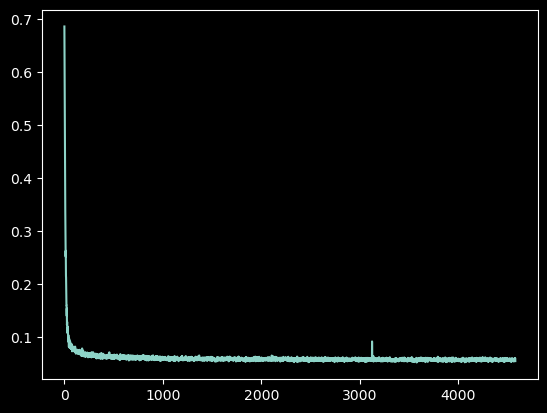

In [11]:
from matplotlib import pyplot as plt
plt.plot(losses)

In [5]:
model

MOEModelForCausalLM(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MOEMLP(
          (mlps): ModuleList(
            (0-2): 3 x GPT2MLP(
              (c_fc): Conv1D()
              (c_proj): Conv1D()
              (act): NewGELUActivation()
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

# autoreload bug

In [14]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import transformers
from torch import nn
import torch
from multihead_models import MOEModelForCausalLM
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR
from matplotlib import pyplot as plt
from tqdm import tqdm 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

dgpt2 = transformers.AutoModelForCausalLM.from_pretrained('distilgpt2')
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token
special_tokens_dict = {"bos_token": "<BOS>", 'eos_token': '<EOS>'}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)

# Preprocess the data: Convert each row to a string
def row_to_string(row):
    return ", ".join([f"{col} is {val}" for col, val in row.items()]) + "."
def row_to_sentences(row):
    return '. '.join([str(col).strip() + " is " + str(val).strip() for col, val in zip(row.index, row.values)])
def row_to_col_sentences(row):
    return [str(col).strip() + " is " + str(val).strip() + '.<EOS>' for col, val in zip(row.index, row.values)]

class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, num_experts, max_length=10, do_moe_format=True):
        self.texts = texts
        self.tokenizer = tokenizer
        self.num_experts = num_experts
        self.max_length = max_length # max col length for MOE format, or max sequence length otherwise
        self.do_moe_format = do_moe_format

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx][:self.num_experts] # ['age is 39.', 'workclass is State-gov.', ...]
        if self.do_moe_format:
            tokenized_text = self.tokenizer(text, truncation=True, max_length=self.max_length, padding='max_length', return_tensors="pt")
            prompt = torch.full((1,), #batch_size x token
                                self.tokenizer.bos_token_id)
            return prompt, tokenized_text.input_ids.squeeze()
        else:
            text = tokenizer.bos_token + ' '.join(text) + tokenizer.eos_token
            tokenized_text = self.tokenizer(text, truncation=True, max_length=self.max_length, padding='max_length', return_tensors='pt')
            return tokenized_text.input_ids.squeeze(), tokenized_text.attention_mask.squeeze()
            
# Load the dataset
file_path = '/hdd3/sonia/data/adult.csv'  # Update this with the correct path
data = pd.read_csv(file_path)
text_data = data.apply(row_to_col_sentences, axis=1).tolist()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/hdd2/sonia/miniconda3/envs/great/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
num_experts = 3
dgpt2copy = MOEModelForCausalLM(dgpt2, num_experts=num_experts)
model = dgpt2copy # don't forget to change tokenizer name and optimizer too

model.train()
# Move the model to the device (GPU if available)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
model.resize_token_embeddings(len(tokenizer))

dataset = TextDataset(text_data, tokenizer, num_experts)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Set up the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-6)

lossesmoe = []
for epoch in range(1):  # Train for 3 epochs
    for batch in dataloader:
        optimizer.zero_grad()
        prompt, labels = batch
        prompt = prompt.to(device)
        labels = labels.to(device)

        outputs = model.multicol_forward(input_ids=prompt, labels=labels)
        # outputs = model.debug_forward(ins['input_ids'].to(device), ins['attention_mask'].to(device), labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()

        lossesmoe.append(loss.item())
        if len(lossesmoe) % 500 == 0:
            torch.save(model.state_dict(), f'./ckpts/moe/dgpt2/adult-1col/debug{len(lossesmoe)}.pt')
            try:
                plt.close()
            except:
                pass
            plt.plot(lossesmoe)
            plt.show()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

Embedding(50259, 768)

100%|██████████| 3053/3053 [03:28<00:00, 14.61it/s]
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


['<|endoftext|>age is 33.<EOS> workclass is Private.<EOS> fnlwgt is 170783']


/hdd2/sonia/miniconda3/envs/great/lib/python3.11/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


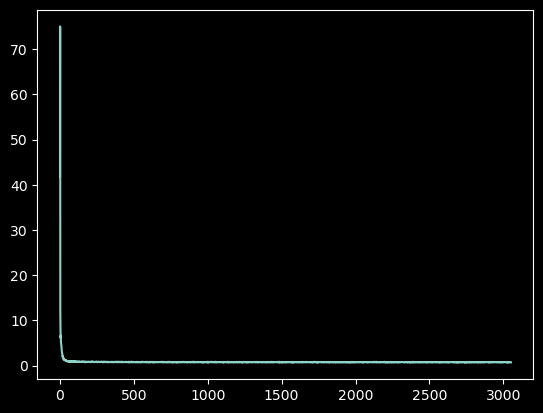

In [15]:
model = dgpt2 # don't forget to change tokenizer name and optimizer too
model.train()
# Move the model to the device (GPU if available)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
model.resize_token_embeddings(len(tokenizer))

dataset = TextDataset(text_data, tokenizer, max_length=25, num_experts=3, do_moe_format=False)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Set up the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-4)
# num_training_steps = len(dataloader) * 1  # Number of epochs
# lr_scheduler = LinearLR(optimizer, total_iters=num_training_steps)

losses = []
for epoch in range(1):  # Train for 3 epochs
    for batch in tqdm(dataloader):
        # print(batch)
        input_ids, attention_mask = batch
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        
print(tokenizer.batch_decode(model.generate()))

from matplotlib import pyplot as plt
plt.plot(losses)

In [23]:
import os
os.makedirs('./ckpts/dgpt2/adult-3col/', exist_ok=True)
torch.save(model.state_dict(), f'./ckpts/dgpt2/adult-3col/{len(losses)}.pt')

samples = []
for i in tqdm(range(5000)):
    samples.append(tokenizer.batch_decode(model.generate(do_sample=True, num_beams=1, max_length=25))[0])

with open('./ckpts/dgpt2/adult-3col/samples.txt', 'w') as f:
    f.write('\n'.join(samples))
    

470660

In [18]:
tokenizer.batch_decode(model.generate(max_length=25)[0])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


['<|endoftext|>',
 'age',
 ' is',
 ' 33',
 '.',
 '<EOS>',
 ' work',
 'class',
 ' is',
 ' Private',
 '.',
 '<EOS>',
 ' f',
 'nl',
 'w',
 'gt',
 ' is',
 ' 16',
 '07',
 '15',
 '.',
 '<EOS>',
 '<EOS>',
 '<|endoftext|>']